## Exam 3 Week 16    

### Add your first and last name here.

#### Value 2000 pts

In [318]:
# basic datascience packages
import numpy as np
import pandas as pd
import random
import math
import os

# geospatial packages
import geopandas as gpd
import pyproj
from pathlib import Path

# time packages
from datetime import datetime
from timezonefinder import TimezoneFinder
import pytz

# gpx parsing package(s)
from gpxcsv import gpxtolist
from gpxpy import gpx
import gpxpy 

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import num2words

import re




### Question 1 (1000 pts)

In [267]:
def compute_dist_deltas(point_array):
    # Compute the distance between successive points in a Point geometry array
    #
    # params:
    #   point_array - array of Point geometry objects
    
    dist = [point_array[i].distance(point_array[i-1]) for i in range(1, len(point_array))]
    dist.insert(0,0)

    return dist

In [279]:
def compute_time_deltas(dt_array, output='hours'):
    # Compute time deltas between records in a datetime array 
    # params:
    #
    #  array of datetime objects
    #  output type: 'seconds' or 'td' or 'timedelta'
    
    delta = np.diff(dt_array).tolist()
    delta.insert(0, pd.Timedelta(seconds=0))
    
    if output == 'seconds':
        return [d.total_seconds() for d in delta]
    elif output in ['td', 'timedelta']:
        return delta
    else:
        print(f'unknown output format {output}')


In [269]:
def compute_pace(td_array, dist_array,win):
# Compute an np_array of instantenous pace at each epoch of a track.
#
# params:
#
#   dist_array = n x 1 array of distance traveled from the last epoch
#   td_array = n x 1 array of time deltas or seconds since the last epoch
#   win = integer defining the size of the average smoothing window (defaults 1 implying no smoothing)
#   The rolling method in pandas is used to perform rolling window calculations on a pandas DataFrame or Series. It allows us to apply various smoothing operators to the data.
#

# The resulting rolling_mean Series will contain the rolling mean values for each window of size 3.    

    # convert timedelta to seconds if necessary
    if type(td_array) == 'timedelta':
        td_array = td_array.total_seconds()

    td_array = np.array(td_array)

    # convert dist_array to a Series object to inable rolling method (could have converted to np_array and used convolve)
    dist_array = pd.Series(dist_array)

    # compute raw or smoothed pace in minutes/mile
    # pace_array = td_array / (dist_array.rolling(window=win).mean())
    pace_array = (td_array / dist_array)*(1690/60)
    pace_array = pace_array.rolling(window=win).mean()

    # replace first element (which is Inf) with 0 (if smoothed you should replace the first win-1)
    #pace_array.iloc[win-1:int(np.floor(win/2))] = 0
    #pace_array.iloc[-int(np.floor(win/2)):-1] = 0
    return pace_array

In [301]:
def create_activity_gdf(filename):
    # Creates a geodataframe using information from a Strava generated GPX file
    #
    # params:
    #   filename: file path and name of the GPX file to be imported
    #
    # output:
    #   a pandas geodataframe of trackpoints and segments

    # Step 1: convert gpx file to a list, and then to panda dataframe
    df = pd.DataFrame(gpxtolist(filename))
    
    required_columns = ['lon', 'lat', 'ele', 'time', 'name', 'type']
    if not all(col in df.columns for col in required_columns):
        print(f"Error: The input data is missing required columns: {set(required_columns) - set(df.columns)}")
        return None

    # Step 2: create a geodataframe (this first to make it easier to infer timezone)
    
    # Step 2a: create 3D geometry object from the appropriate columns
    trk = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'],df['lat'],df['ele']))

    # Step 2b: define the current reference system as WGS84 (this is the default GPS system)
    trk = trk.set_crs('epsg:4326')

    # Step 2c: convert from WGS84 to UTM in meters so we can work with it more easily
    trk = trk.to_crs(epsg=32615)

    # Step 3: convert times to datatime objects
   
    # Step 3a: determine correct timezone
    query_points = [(trk['lon'][1], trk['lat'][1])]
    tf = TimezoneFinder()
    tz_local = tf.timezone_at(lng=trk['lon'][1], lat=trk['lat'][1])

    # Step 3b: localize the gpx supplied timezone (always GMT)
    trk['time'] = pd.to_datetime(trk['time'], format='%Y-%m-%dT%H:%M:%SZ')
    trk['time'] = trk['time'].dt.tz_localize(pytz.timezone('GMT'))

    # Step 3c: convert to timezone based on location of the run
    trk['time'] = trk['time'].dt.tz_convert(tz_local)

    # Print enough information to have confidence geodataframe is correct

    # Note that we do not create time or distance delta columnshere because they change if we remove rows (epochs), they will be invalid.
    # Better to do this as needed with these simple calls
    dist_array = [trk.geometry[i].distance(trk.geometry[i-1]) for i in range(1, len(trk.geometry))]
    total_dist = sum(dist_array)/1609
    total_time = (trk.time.iloc[-1] - trk.time.iloc[0]).total_seconds()/60
    
    return trk

In [321]:
def analyze_heart_rate_vs_pace(files, smooth, plot=True):
    """
    Analyze heart rate as a function of pace from a list of GPX files.
    
    :param files: List of GPX files to analyze.
    :param smooth: Boolean flag to determine whether to smooth the pace.
    :param plot: Boolean flag to determine whether to plot the results.
    
    :return: A list of model objects from the linear regression of each file.
    """
    model_list = []  # List to store the model objects
    
    plt.figure(figsize=(10, 6))
    
    # Loop through each file and process it
    for filename in files:
        print(f"Processing {filename}")
        df = create_activity_gdf(filename)  # Assuming create_activity_gdf is defined
        
        if df is None:
            continue
        
        if df["type"].isnull().any() or df["time"].isnull().any():
            continue
        
        activity_type = df["type"].iloc[0]  # Get the activity type for the file
        if activity_type not in ["running", "walking", "hiking"]:
            print(f"Skipping file {filename} as it's not a running, walking, or hiking activity (type: {activity_type}).")
            continue
        
        # Compute pace (using placeholder for compute_pace and other necessary functions)
        # Pass smooth as True or False to decide whether to smooth in compute_pace
        df['pace'] = compute_pace(compute_time_deltas(df.time, 'seconds'), compute_dist_deltas(df.geometry), win=12 if smooth else 1)
        
        # Handle NaN or missing values in 'heart_rate' and 'pace'
        df = df.dropna(subset=['hr', 'pace'])
        
        # Extract independent and dependent variables
        X = df[['pace']].values  # Independent variable (pace)
        y = df['hr'].values  # Dependent variable (heart rate)
        
        # Initialize Linear Regression model
        model = LinearRegression()
        
        # Fit the model
        model.fit(X, y)
        
        # Get the regression line
        y_pred = model.predict(X)

        # Sort data by pace for a smooth line plot
        df_sorted = df.sort_values(by='pace')
        
        # Plot the data points and regression line for each file (with transparency)
        if plot:
            plt.plot(df_sorted['pace'], df_sorted['hr'], marker='o', linestyle='-', markersize=5, alpha=0.5)
            plt.plot(df_sorted['pace'], model.predict(df_sorted[['pace']]), linewidth=2)
        
        # Add the model to the list of models
        model_list.append(model)
    
    # Titles and labels
    plt.title('Heart Rate vs Pace for Multiple Activities')
    plt.xlabel('Pace (m/s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    
    # Show the plot
    if plot:
        plt.show()
    
    return model_list


Processing Data\Strava\Track-1.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-10.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-11.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-12.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-13.gpx
Error: The input data is missing required columns: {'time'}
Processing Data\Strava\Track-14.gpx
Error: The input data is missing required columns: {'time'}
Processing Data\Strava\Track-2.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-3.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-4.gpx
Error: The input data is missing required columns: {'type'}
Processing Data\Strava\Track-5.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-6.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-7.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-8.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Processing Data\Strava\Track-9.gpx


C:\Users\iphon\PycharmProjects\Exam\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


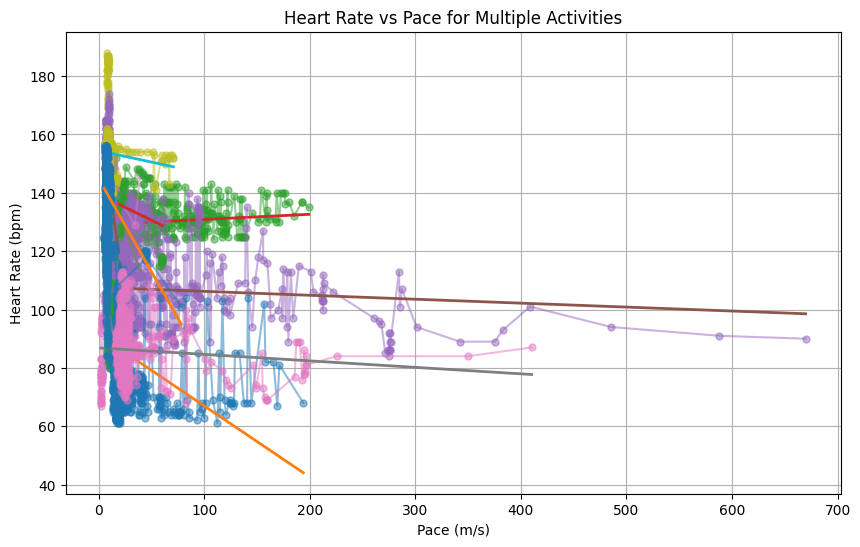

In [322]:
filenames = [str(Path('./Data/Strava') / filename) for filename in os.listdir('./Data/Strava') if filename.endswith('.gpx')]
#The smoothing window inside the function is set to 7...
models = analyze_heart_rate_vs_pace(filenames, smooth=True, plot=True)



### Question 2 (1000 pts)

In [331]:
nltk.download('stopwords', quiet=True)

class DocumentRanker:
    def __init__(self, stories_path):
        self.stories_path = stories_path
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.dataset = []
        self.processed_text = []
        self.processed_title = []
        
    def crawl_folders(self):
        """Crawl through stories folders"""
        folders = [x[0] for x in os.walk(self.stories_path)]
        folders[0] = folders[0][:len(folders[0])-1]
        return folders
    
    def extract_titles_and_names(self, folders):
        """Extract titles and file names from index.html files"""
        dataset = []
        c = False
        
        for folder in folders:
            try:
                with open(os.path.join(folder, "index.html"), 'r', encoding='utf-8') as file:
                    text = file.read().strip()
                
                file_names = re.findall('><A HREF="(.*)">', text)
                file_titles = re.findall('<BR><TD> (.*)\n', text)
                
                if not c:
                    file_names = file_names[2:]
                    c = True
                
                for j in range(len(file_names)):
                    dataset.append((os.path.join(folder, file_names[j]), file_titles[j]))
            except Exception as e:
                print(f"Error reading {folder}/index.html: {e}")
        
        return dataset
    
    def convert_lower_case(self, data):
        """Convert text to lowercase"""
        return np.char.lower(data)
    
    def remove_punctuation(self, data):
        """Remove punctuation from text"""
        symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
        for symbol in symbols:
            data = np.char.replace(data, symbol, ' ')
        return data
    
    def remove_apostrophe(self, data):
        """Remove apostrophes"""
        return np.char.replace(data, "'", "")
    
    def remove_single_characters(self, data):
        """Remove single characters"""
        return np.array([' '.join([word for word in text.split() if len(word) > 1]) for text in data])
    
    def remove_stop_words(self, data):
        """Remove stop words"""
        return np.array([' '.join([word for word in text.split() if word not in self.stop_words]) for text in data])
    
    def convert_numbers(self, data):
        """Convert numbers to words"""
        return np.array([' '.join([num2words.num2words(word) if word.isdigit() else word for word in text.split()]) for text in data])
    
    def stemming(self, data):
        """Apply stemming to words"""
        return np.array([' '.join([self.stemmer.stem(word) for word in text.split()]) for text in data])
    
    def preprocess(self, data):
        """Complete preprocessing pipeline"""
        data = self.convert_lower_case(data)
        data = self.remove_punctuation(data)
        data = self.remove_apostrophe(data)
        data = self.remove_single_characters(data)
        data = self.convert_numbers(data)
        data = self.remove_stop_words(data)
        data = self.stemming(data)
        data = self.remove_punctuation(data)
        data = self.convert_numbers(data)
        return data
    
    def calculate_document_frequency(self, processed_text):
        """Calculate document frequency for tokens"""
        DF = {}
        for doc_id, tokens in enumerate(processed_text):
            for word in tokens.split():
                if word in DF:
                    DF[word].add(doc_id)
                else:
                    DF[word] = {doc_id}
        
        # Convert set to count
        return {word: len(docs) for word, docs in DF.items()}
    
    def calculate_tf_idf(self, processed_text, processed_title, alpha=0.7):
        """Calculate TF-IDF with weighted title and body"""
        N = len(processed_text)
        
        # Calculate document frequency
        doc_freq = self.calculate_document_frequency(processed_text)
        
        tf_idf = {}
        tf_idf_title = {}
        
        for i in range(N):
            tokens = processed_text[i].split()
            title_tokens = processed_title[i].split()
            
            counter = Counter(tokens + title_tokens)
            words_count = len(tokens + title_tokens)
            
            for token in set(tokens):
                tf = counter[token] / words_count
                df = doc_freq.get(token, 1)  # Prevent division by zero
                idf = np.log(N / (df + 1))
                tf_idf[(i, token)] = tf * idf
            
            for token in set(title_tokens):
                tf = counter[token] / words_count
                df = doc_freq.get(token, 1)  # Prevent division by zero
                idf = np.log(N / (df + 1))
                tf_idf_title[(i, token)] = tf * idf
        
        # Apply weighted combination
        for key in tf_idf:
            tf_idf[key] *= alpha
            if key in tf_idf_title:
                tf_idf[key] += tf_idf_title[key] * (1 - alpha)
        
        return tf_idf
    
    def matching_score(self, query, tf_idf):
        """Calculate matching score for query"""
        query_tokens = self.preprocess([query])[0].split()
        query_weights = {}
        
        for key, value in tf_idf.items():
            doc_id, token = key
            if token in query_tokens:
                query_weights[doc_id] = query_weights.get(doc_id, 0) + value
        
        return sorted(query_weights.items(), key=lambda x: x[1], reverse=True)
    
    def process_documents(self):
        """Process all documents in the dataset"""
        folders = self.crawl_folders()
        self.dataset = self.extract_titles_and_names(folders)
        
        text_data = [open(os.path.join(doc[0]), 'r', encoding='utf-8', errors='ignore').read() for doc in self.dataset]
        titles = [doc[1] for doc in self.dataset]
        
        processed_text = self.preprocess(text_data)
        processed_title = self.preprocess(titles)
        
        self.processed_text = processed_text
        self.processed_title = processed_title
        
        return processed_text, processed_title
    
    def rank_documents(self, query, top_k):
        """Rank documents for a given query"""
        processed_text, processed_title = self.process_documents()
        tf_idf = self.calculate_tf_idf(processed_text, processed_title)
        
        ranked_docs = self.matching_score(query, tf_idf)
        
        return [(self.dataset[doc_id][0], self.dataset[doc_id][1], score) for doc_id, score in ranked_docs[:top_k]]

if __name__ == "__main__":
    ranker = DocumentRanker('./Data/stories')
    results = ranker.rank_documents("machine learning", top_k=10)
    for i, (doc_path, doc_title, score) in enumerate(results, 1):
        print(f"{i}. Path: {doc_path}")
        print(f"   Title: {doc_title}")
        print(f"   Score: {score:.4f}\n")

<>:48: SyntaxWarning: invalid escape sequence '\]'
<>:48: SyntaxWarning: invalid escape sequence '\]'
C:\Users\iphon\AppData\Local\Temp\ipykernel_10096\3053979866.py:48: SyntaxWarning: invalid escape sequence '\]'
  symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"


Error reading ./Data/storie/index.html: [Errno 2] No such file or directory: './Data/storie\\index.html'
1. Path: ./Data/stories\SRE\sre_finl.txt
   Title: Solar Realms Elite: The Finale by Josh Renaud
   Score: 0.0009

2. Path: ./Data/stories\SRE\sre10.txt
   Title: Solar Realms Elite X: Legacies, by Josh Renaud
   Score: 0.0007

3. Path: ./Data/stories\SRE\srex.txt
   Title: Solar Realms Elite: X1 and X2, by Josh Renaud
   Score: 0.0004

4. Path: ./Data/stories\SRE\sre03.txt
   Title: Solar Realms Elite: Ultra's Untold Story by Josh Renaud
   Score: 0.0004

5. Path: ./Data/stories\SRE\sre01.txt
   Title: SRE: The Saga Of The Best SRE Game Ever Played! By Josh Renaud
   Score: 0.0002

6. Path: ./Data/stories\SRE\sre04.txt
   Title: Solar Realms Elite IV: The Confrontation, by Josh Renaud
   Score: 0.0002

7. Path: ./Data/stories\SRE\sre08.txt
   Title: Solar Realms Elite VIII: Kazik, by Josh Renaud
   Score: 0.0002

8. Path: ./Data/stories\SRE\sre05.txt
   Title: Solar Realms Elite V:

### Question 3 (Extra Credit 400 pts)

In [ ]:
# Provide your answer in the cells here and below.